In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re


sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.preselection.ranked_quadh

signal = ObjIter([Tree(fn, use_gen=False) for fn in module.signal_list[::3]])
# signal = ObjIter([Tree(module.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
# signal_asym = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(module.QCD_B_List, use_gen=False)])
# qcd_asym = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])
ttbar = ObjIter([Tree(module.TTJets, use_gen=False)])
# ttbar = ObjIter([])
# qcd = ObjIter([])

100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


In [3]:
bkg = qcd + ttbar

In [4]:
for t in signal:
  t.color = None

In [5]:
def btagmulti(t):
  btags = ak_stack([ t[f'{obj}_btag'] for obj in eightb.quarklist ])
  btagavg = ak.mean(btags,axis=-1)
  multi = { f'n_{label}_btag':ak.sum(btags>wp,axis=-1) for wp,label in zip(jet_btagWP, wplabels) }
  t.extend(btagavg=btagavg, **multi)
(signal+bkg).apply(btagmulti)

[None, None, None, None, None]

In [6]:
def jet_relpt(t):
  pts = ak_stack([ t[f'{obj}_ptRegressed'] for obj in eightb.quarklist ])
  x_unit = np.sqrt( t.X_m**2 + t.X_pt**2 )
  x_rel_pts = pts/x_unit

  y1_rel_pts = pts[:,:4]/x_unit

  y2_rel_pts = pts[:,4:]/x_unit

  t.extend(x_rel_ht=ak.sum(x_rel_pts,axis=-1), y1_rel_ht=ak.sum(y1_rel_pts,axis=-1), y2_rel_ht=ak.sum(y2_rel_pts,axis=-1))
(signal+bkg).apply(jet_relpt)

[None, None, None, None, None]

100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


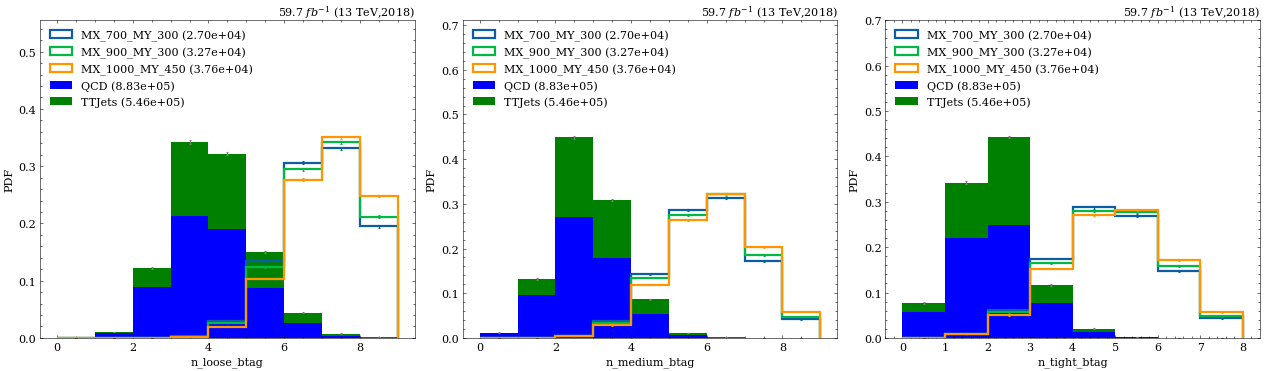

In [7]:
study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
  dim=(-1,3),
  efficiency=True,
  # saveas='btagmulti'
)

100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


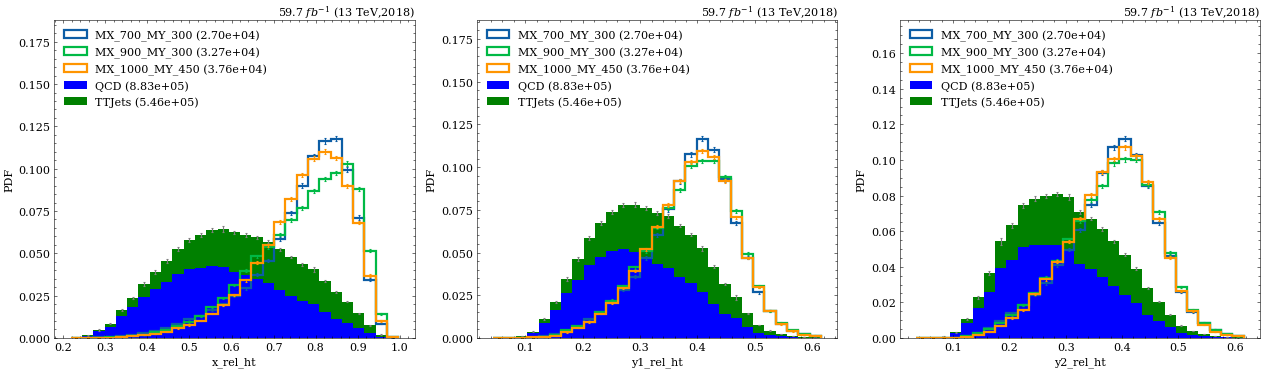

In [8]:
study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=['x_rel_ht','y1_rel_ht','y2_rel_ht'],
  dim=(-1,3),
  efficiency=True,
)

100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


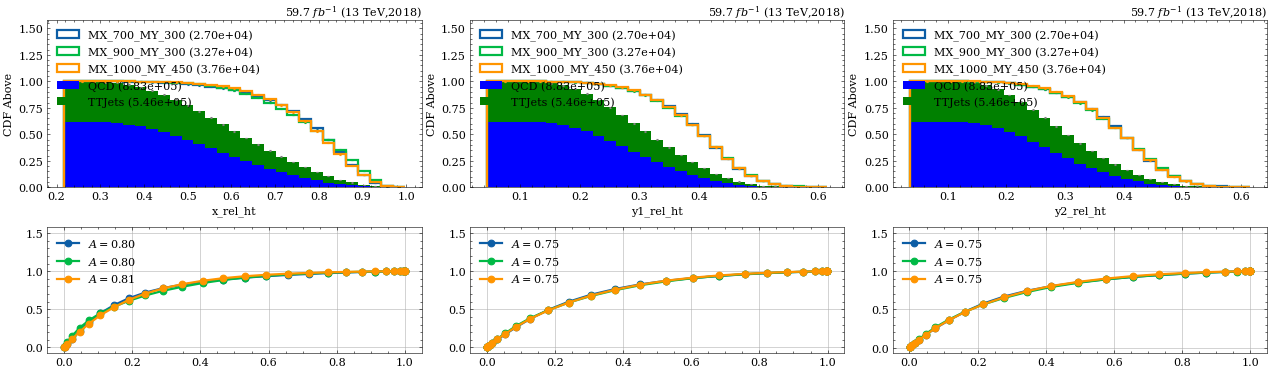

In [9]:
study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=['x_rel_ht','y1_rel_ht','y2_rel_ht'],
  dim=(-1,3),
  efficiency=True,
  cumulative=-1,
  correlation=True,
)

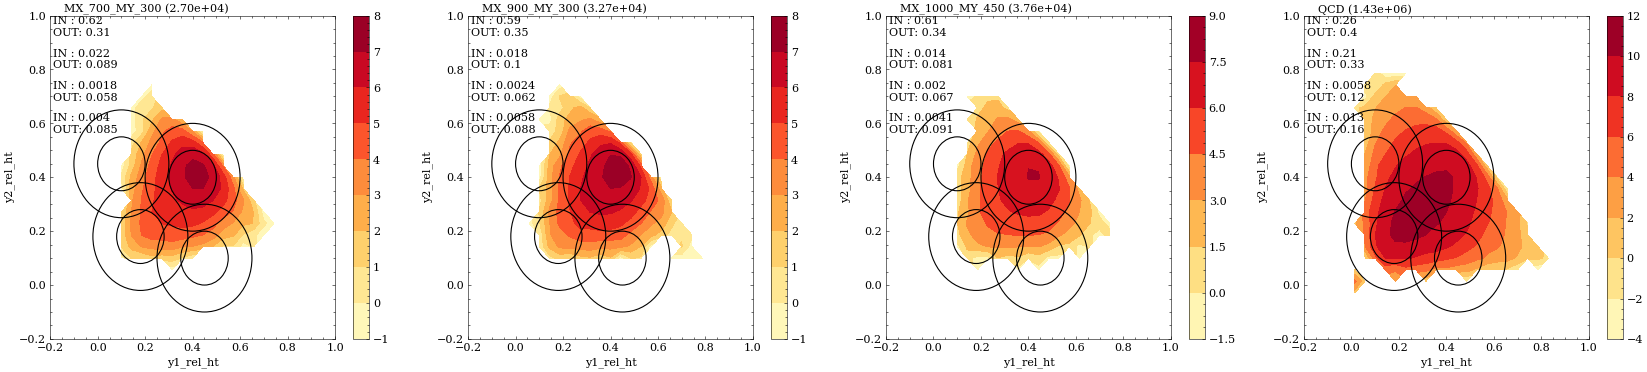

In [10]:
varinfo.y1_rel_ht=dict(bins=(-0.2,1.0,30))
varinfo.y2_rel_ht=dict(bins=(-0.2,1.0,30))
study.quick2d_region(
  signal[[0]],signal[[1]],signal[[2]], bkg, stacked=True,
  varlist=['y1_rel_ht','y2_rel_ht'], log=True,
  dim=(-1,4), contour=True,
  exe=[
      draw_concentric(0.4 , 0.4 , 0.1 , 0.2), 
      draw_concentric(0.18, 0.18, 0.1 , 0.2, text=(0,0.9)), 
      draw_concentric(0.1 , 0.45, 0.1 , 0.2, text=(0,0.8)), 
      draw_concentric(0.45, 0.1 , 0.1 , 0.2, text=(0,0.7)), 
      ]
  # exe=draw_circle(0.44,0.44,0.1)
)

100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


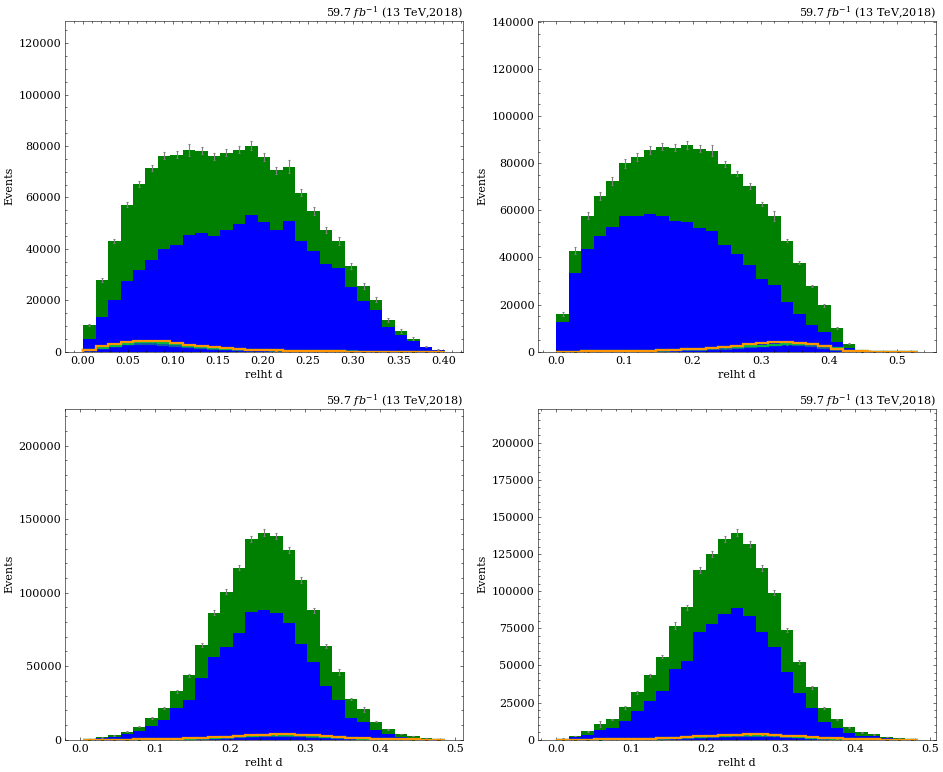

In [11]:
class relht_d(ObjTransform):
  def init(self): self.xlabel='relht d'
  def __call__(self, t):
    d = np.sqrt((t.y1_rel_ht-self.x)**2 + (t.y2_rel_ht-self.y)**2)
    return d
  

study.quick(
  bkg+signal, stacked=True,
  varlist=[ relht_d(x=0.4,y=0.4),relht_d(x=0.18,y=0.18),relht_d(x=0.15,y=0.45),relht_d(x=0.45,y=0.15), ]
)

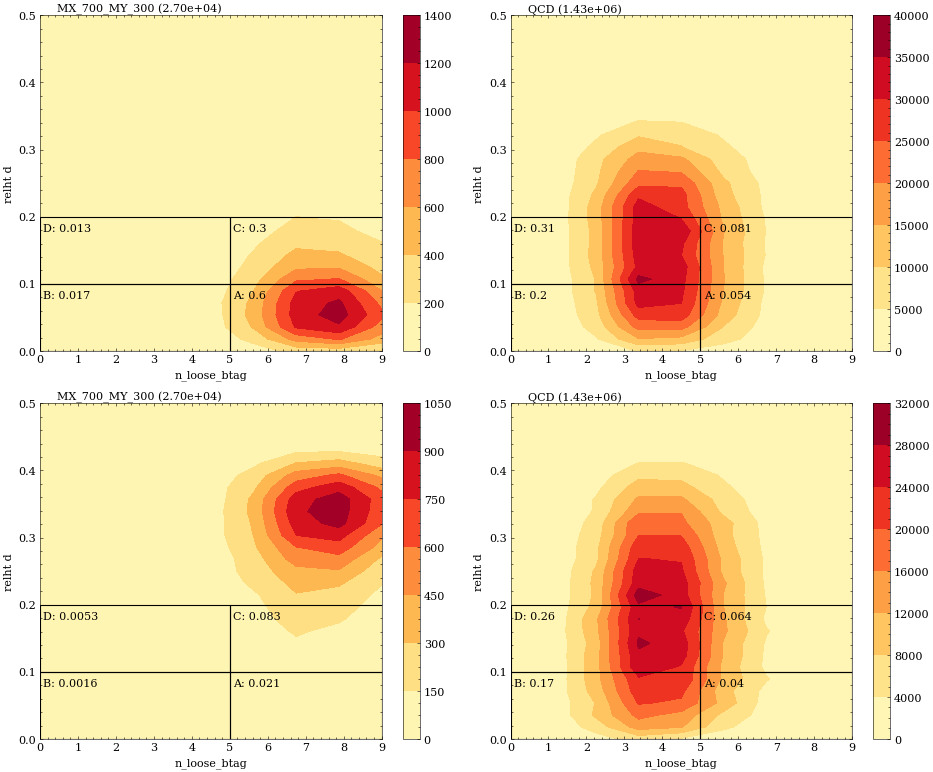

In [12]:

study.quick2d_region(
  signal[[0]], bkg, stacked=True,
  xvarlist=['n_loose_btag']*2,
  yvarlist=[ relht_d(x=0.4,y=0.4),relht_d(x=0.18,y=0.18) ],
  ybinlist=[ (0,0.5,30) ]*2,
  exe=draw_abcd((0,5,9),(0,0.1,0.2), swapy=True),
  contour=True,
)

In [13]:
get_relht_d = relht_d(x=0.18,y=0.18)
get_relht_d = relht_d(x=0.4,y=0.4)
a = lambda t : (t.n_loose_btag > 4) & (0 < get_relht_d(t)) & (get_relht_d(t) < 0.1)
b = lambda t : (t.n_loose_btag <=4) & (0 < get_relht_d(t)) & (get_relht_d(t) < 0.1)
c = lambda t : (t.n_loose_btag > 4) & (0.1 < get_relht_d(t)) & (get_relht_d(t) < 0.2)
d = lambda t : (t.n_loose_btag <=4) & (0.1 < get_relht_d(t)) & (get_relht_d(t) < 0.2)
abcd = ABCD(["X_m","X_pt"], a=a, b=b, c=c, d=d)
abcd.train(bkg)
abcd.results(bkg)

--- ABCD Results ---
k = 2.581e-01
k*(b/a)-1  = -2.413e-02
BDT(b)/a-1 = -1.599e-02



100%|██████████| 2/2 [00:05<00:00,  2.69s/it]


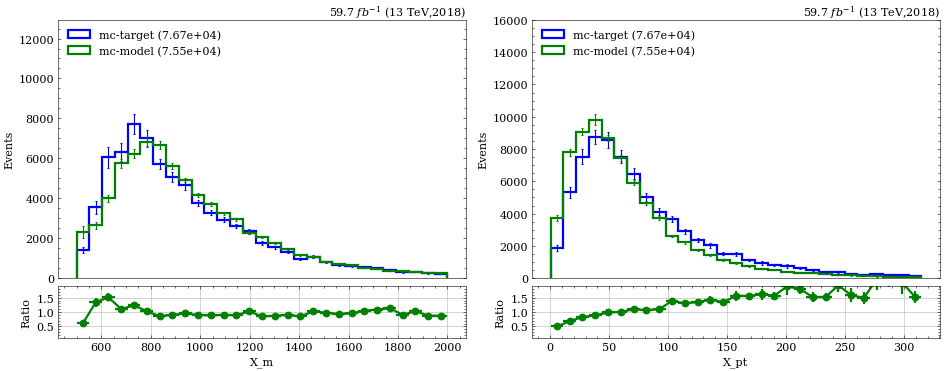

In [15]:
study.quick_region(
  bkg, bkg, label=['mc-target','mc-model'],
  legend=True,
  masks=[a]*len(bkg)+[b]*len(bkg),
  scale=[1]*len(bkg)+[abcd.reweight_tree]*len(bkg),
  varlist=['X_m','X_pt'],
  ratio=True,
)

In [16]:
signal

[<utils.classUtils.Tree.Tree object at 0x7f54746c3250>, <utils.classUtils.Tree.Tree object at 0x7f5477b4fe80>, <utils.classUtils.Tree.Tree object at 0x7f5476726310>]

100%|██████████| 1/1 [00:15<00:00, 15.05s/it]


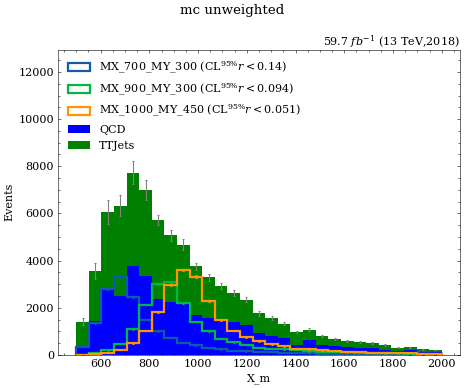

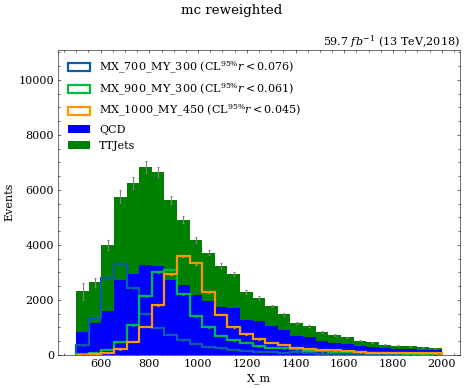

In [23]:
study.quick(
  bkg + signal, 
  stacked=True,
  legend=True,
  masks=[a]*len(bkg)+[a]*len(signal),
  # scale=[1]*len(bkg),
  varlist=['X_m',],
  title='mc unweighted',
  limits=True,  
)

study.quick(
  bkg + signal, 
  stacked=True,
  legend=True,
  masks=[b]*len(bkg)+[a]*len(signal),
  scale=[abcd.reweight_tree]*len(bkg)+[1]*len(signal),
  varlist=['X_m',],
  title='mc reweighted',
  limits=True,
)